In [1]:
class OptionPricing:
    def __init__(self, S0, K, T, r):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r

In [2]:
import numpy as np
from scipy.optimize import minimize

class OptionPricing:
    def __init__(self, S0, K, T, r):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r

    def monte_carlo_simulation(self, N, M):
        raise NotImplementedError("Must be implemented by subclasses")

    def price_option(self, N, M):
        raise NotImplementedError("Must be implemented by subclasses")

In [3]:
class BlackScholesModel(OptionPricing):
    def __init__(self, S0, K, T, r, sigma):
        super().__init__(S0, K, T, r)
        self.sigma = sigma

    def monte_carlo_simulation(self, N, M):
        dt = self.T / M
        price_paths = np.zeros((N, M + 1))
        price_paths[:, 0] = self.S0
        for t in range(1, M + 1):
            Z = np.random.standard_normal(N)
            price_paths[:, t] = price_paths[:, t - 1] * np.exp((self.r - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * Z)
        return price_paths

    def price_option(self, N, M):
        price_paths = self.monte_carlo_simulation(N, M)
        payoffs = np.maximum(price_paths[:, -1] - self.K, 0)
        return np.exp(-self.r * self.T) * np.mean(payoffs)
    
    def calibrate(self, market_prices, strikes, maturities):
        def objective_function(params):
            self.sigma = params[0]
            model_prices = [self.price_option(10000, 100) for K, T in zip(strikes, maturities)]
            return np.sum((np.array(market_prices) - np.array(model_prices))**2)
        
        result = minimize(objective_function, [self.sigma], bounds=[(0.01, 1.0)])
        self.sigma = result.x[0]

In [4]:
class StochasticVolatilityModel(OptionPricing):
    def __init__(self, S0, K, T, r, v0, kappa, theta, xi, rho):
        super().__init__(S0, K, T, r)
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho

    def monte_carlo_simulation(self, N, M):
        dt = self.T / M
        price_paths = np.zeros((N, M + 1))
        vol_paths = np.zeros((N, M + 1))
        price_paths[:, 0] = self.S0
        vol_paths[:, 0] = self.v0
        for t in range(1, M + 1):
            Z1 = np.random.standard_normal(N)
            Z2 = np.random.standard_normal(N)
            W1 = Z1
            W2 = self.rho * Z1 + np.sqrt(1 - self.rho**2) * Z2
            vol_paths[:, t] = np.abs(vol_paths[:, t - 1] + self.kappa * (self.theta - vol_paths[:, t - 1]) * dt + self.xi * np.sqrt(vol_paths[:, t - 1] * dt) * W1)
            price_paths[:, t] = price_paths[:, t - 1] * np.exp((self.r - 0.5 * vol_paths[:, t - 1]) * dt + np.sqrt(vol_paths[:, t - 1] * dt) * W2)
        return price_paths

    def price_option(self, N, M):
        price_paths = self.monte_carlo_simulation(N, M)
        payoffs = np.maximum(price_paths[:, -1] - self.K, 0)
        return np.exp(-self.r * self.T) * np.mean(payoffs)
    
    def calibrate(self, market_prices, strikes, maturities):
        def objective_function(params):
            self.v0, self.kappa, self.theta, self.xi, self.rho = params
            model_prices = [self.price_option(10000, 100) for K, T in zip(strikes, maturities)]
            return np.sum((np.array(market_prices) - np.array(model_prices))**2)
        
        initial_guess = [self.v0, self.kappa, self.theta, self.xi, self.rho]
        bounds = [(0.01, 1.0), (0.01, 5.0), (0.01, 1.0), (0.01, 1.0), (-1.0, 1.0)]
        result = minimize(objective_function, initial_guess, bounds=bounds)
        self.v0, self.kappa, self.theta, self.xi, self.rho = result.x

In [5]:
def generate_synthetic_market_data(model, strikes, maturities):
    market_prices = [model.price_option(10000, 100) for K, T in zip(strikes, maturities)]
    return market_prices

In [6]:
# Parameters for synthetic data
S0 = 100
r = 0.05
true_sigma = 0.2
true_v0 = 0.2
true_kappa = 2.0
true_theta = 0.2
true_xi = 0.1
true_rho = -0.5

strikes = [90, 95, 100, 105, 110]
maturities = [0.5, 1.0, 1.5, 2.0]

# Generate synthetic market data using the true parameters
bs_model = BlackScholesModel(S0, 100, 1, r, true_sigma)
bs_market_prices = generate_synthetic_market_data(bs_model, strikes, maturities)

sv_model = StochasticVolatilityModel(S0, 100, 1, r, true_v0, true_kappa, true_theta, true_xi, true_rho)
sv_market_prices = generate_synthetic_market_data(sv_model, strikes, maturities)

# Calibrate models
bs_model.calibrate(bs_market_prices, strikes, maturities)
print("Calibrated sigma:", bs_model.sigma)

sv_model.calibrate(sv_market_prices, strikes, maturities)
print("Calibrated parameters: v0 =", sv_model.v0, ", kappa =", sv_model.kappa, ", theta =", sv_model.theta, ", xi =", sv_model.xi, ", rho =", sv_model.rho)

Calibrated sigma: 0.2000000054226391
Calibrated parameters: v0 = 0.2000002546685129 , kappa = 2.000000730708405 , theta = 0.20000025110390834 , xi = 0.10000012490597794 , rho = -0.49999954651172007


In [8]:
import matplotlib.pyplot as plt

class KnockoutOption:
    def __init__(self, model, S0, K, T, r, barrier):
        self.model = model
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.barrier = barrier

    def price_knockout_option(self, N, M):
        dt = self.T / M
        price_paths = np.zeros((N, M + 1))
        vol_paths = np.zeros((N, M + 1)) if isinstance(self.model, StochasticVolatilityModel) else None
        price_paths[:, 0] = self.S0
        if vol_paths is not None:
            vol_paths[:, 0] = self.model.v0
        
        for t in range(1, M + 1):
            Z1 = np.random.standard_normal(N)
            if vol_paths is None:
                # Black-Scholes Model
                price_paths[:, t] = price_paths[:, t - 1] * np.exp(
                    (self.r - 0.5 * self.model.sigma**2) * dt + self.model.sigma * np.sqrt(dt) * Z1
                )
            else:
                # Stochastic Volatility Model
                Z2 = np.random.standard_normal(N)
                W1 = Z1
                W2 = self.model.rho * Z1 + np.sqrt(1 - self.model.rho**2) * Z2
                vol_paths[:, t] = np.abs(vol_paths[:, t - 1] + self.model.kappa * (self.model.theta - vol_paths[:, t - 1]) * dt + self.model.xi * np.sqrt(vol_paths[:, t - 1] * dt) * W1)
                price_paths[:, t] = price_paths[:, t - 1] * np.exp(
                    (self.r - 0.5 * vol_paths[:, t - 1]) * dt + np.sqrt(vol_paths[:, t - 1] * dt) * W2
                )
            
            # Knockout condition
            price_paths[:, t][price_paths[:, t] >= self.barrier] = 0
        
        payoffs = np.maximum(price_paths[:, -1] - self.K, 0)
        return np.exp(-self.r * self.T) * np.mean(payoffs)

In [9]:
class BlackScholesModel:
    def __init__(self, S0, K, T, r, sigma):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma

class StochasticVolatilityModel:
    def __init__(self, S0, K, T, r, v0, kappa, theta, xi, rho):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.xi = xi
        self.rho = rho

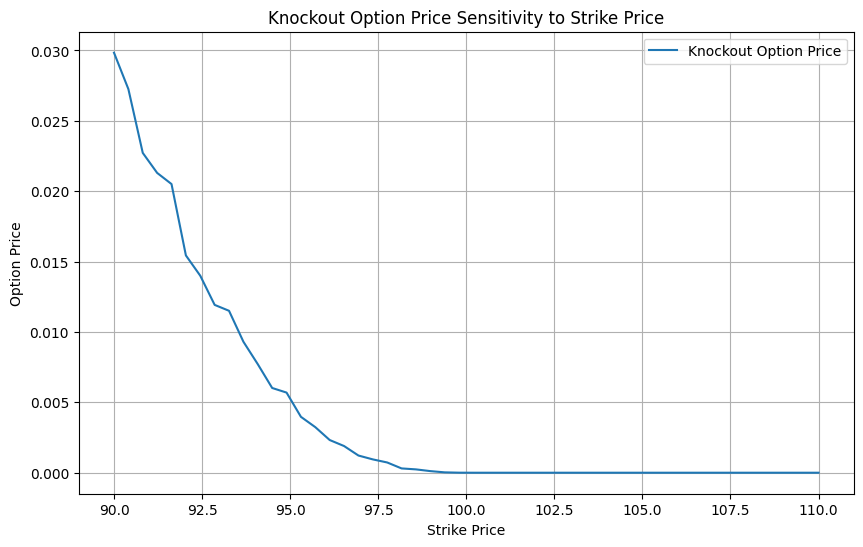

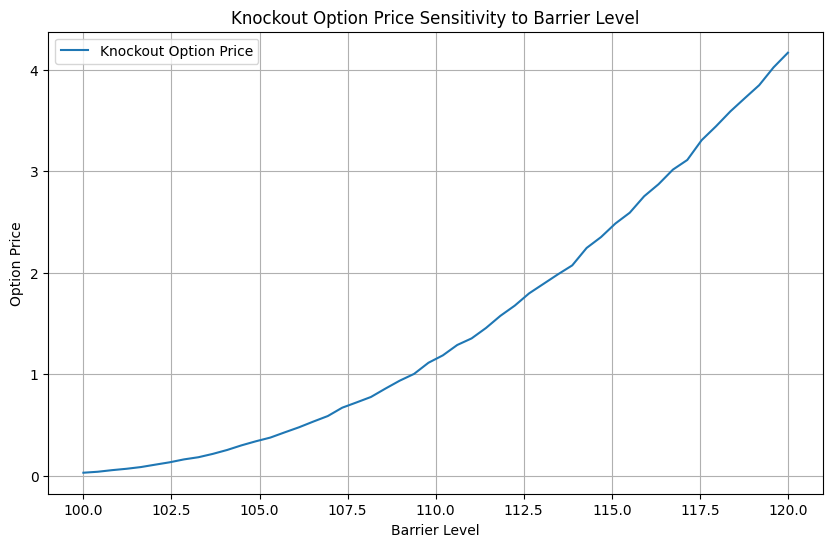

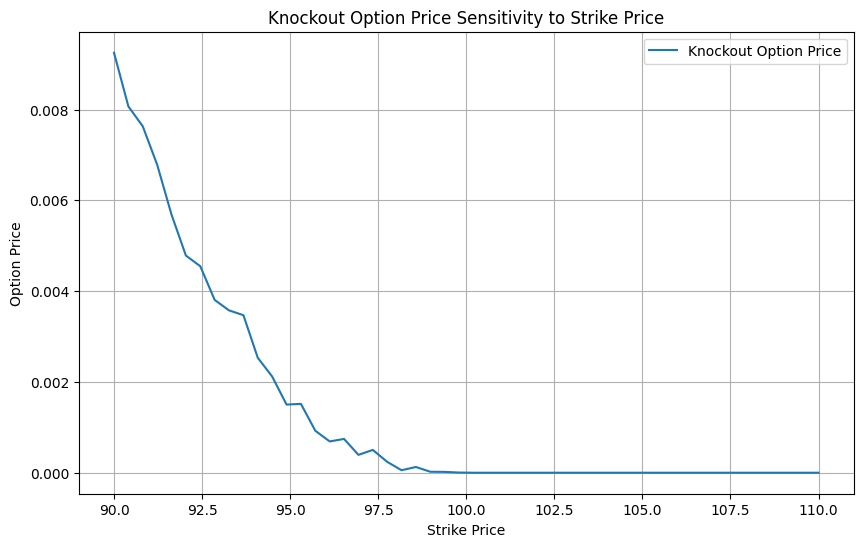

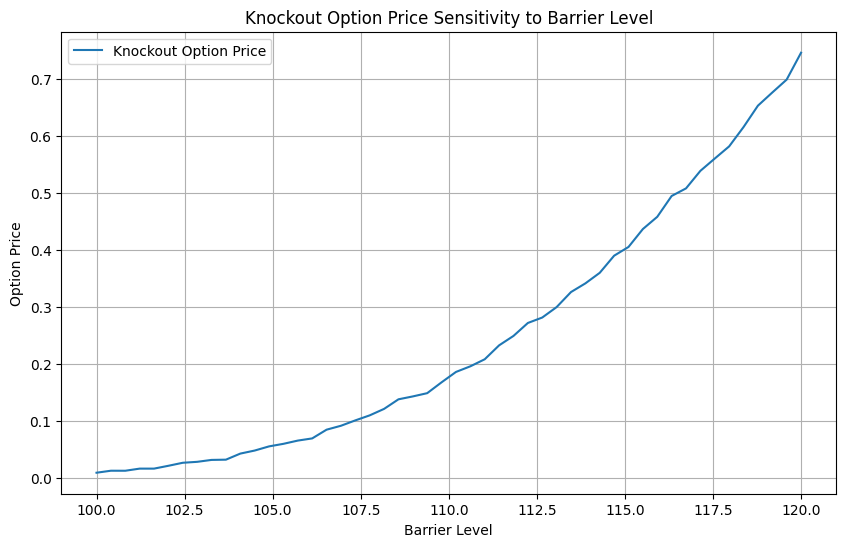

In [10]:
def sensitivity_testing(model_type, S0, T, r, N, M, strike_range=None, barrier_range=None, **model_params):
    if strike_range:
        strike_prices = np.linspace(strike_range[0], strike_range[1], 50)
        knockout_prices_strike = []

        for K in strike_prices:
            if model_type == 'BS':
                model = BlackScholesModel(S0, K, T, r, model_params['sigma'])
            else:
                model = StochasticVolatilityModel(S0, K, T, r, model_params['v0'], model_params['kappa'], model_params['theta'], model_params['xi'], model_params['rho'])
            
            knockout_option = KnockoutOption(model, S0, K, T, r, barrier_range[0])
            price = knockout_option.price_knockout_option(N, M)
            knockout_prices_strike.append(price)
        
        plt.figure(figsize=(10, 6))
        plt.plot(strike_prices, knockout_prices_strike, label='Knockout Option Price')
        plt.xlabel('Strike Price')
        plt.ylabel('Option Price')
        plt.title('Knockout Option Price Sensitivity to Strike Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    if barrier_range:
        barriers = np.linspace(barrier_range[0], barrier_range[1], 50)
        knockout_prices_barrier = []

        for barrier in barriers:
            if model_type == 'BS':
                model = BlackScholesModel(S0, strike_range[0], T, r, model_params['sigma'])
            else:
                model = StochasticVolatilityModel(S0, strike_range[0], T, r, model_params['v0'], model_params['kappa'], model_params['theta'], model_params['xi'], model_params['rho'])
            
            knockout_option = KnockoutOption(model, S0, strike_range[0], T, r, barrier)
            price = knockout_option.price_knockout_option(N, M)
            knockout_prices_barrier.append(price)
        
        plt.figure(figsize=(10, 6))
        plt.plot(barriers, knockout_prices_barrier, label='Knockout Option Price')
        plt.xlabel('Barrier Level')
        plt.ylabel('Option Price')
        plt.title('Knockout Option Price Sensitivity to Barrier Level')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage:
S0 = 100
T = 1
r = 0.05
N = 100000
M = 100
strike_range = (90, 110)
barrier_range = (100, 120)

# Black-Scholes Model Sensitivity Testing
sensitivity_testing('BS', S0, T, r, N, M, strike_range=strike_range, barrier_range=barrier_range, sigma=0.2)

# Stochastic Volatility Model Sensitivity Testing
sensitivity_testing('SV', S0, T, r, N, M, strike_range=strike_range, barrier_range=barrier_range, v0=0.2, kappa=2.0, theta=0.2, xi=0.1, rho=-0.5)